In [3]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
df = pd.read_csv("clean_email_dataset.csv", encoding="utf-8")

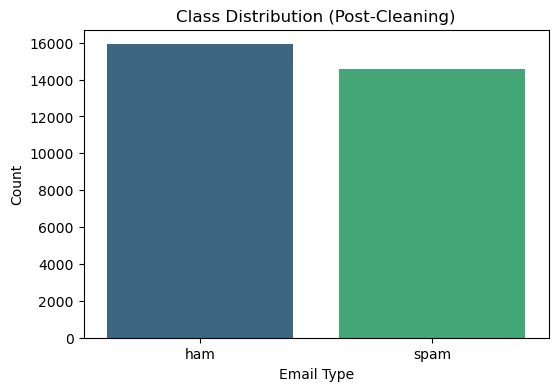

In [7]:
# STEP 1 -> CHECK CLASS DISTRIBUTION (SPAM / HAM)
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"], palette="viridis")
plt.title("Class Distribution (Post-Cleaning)")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.show()

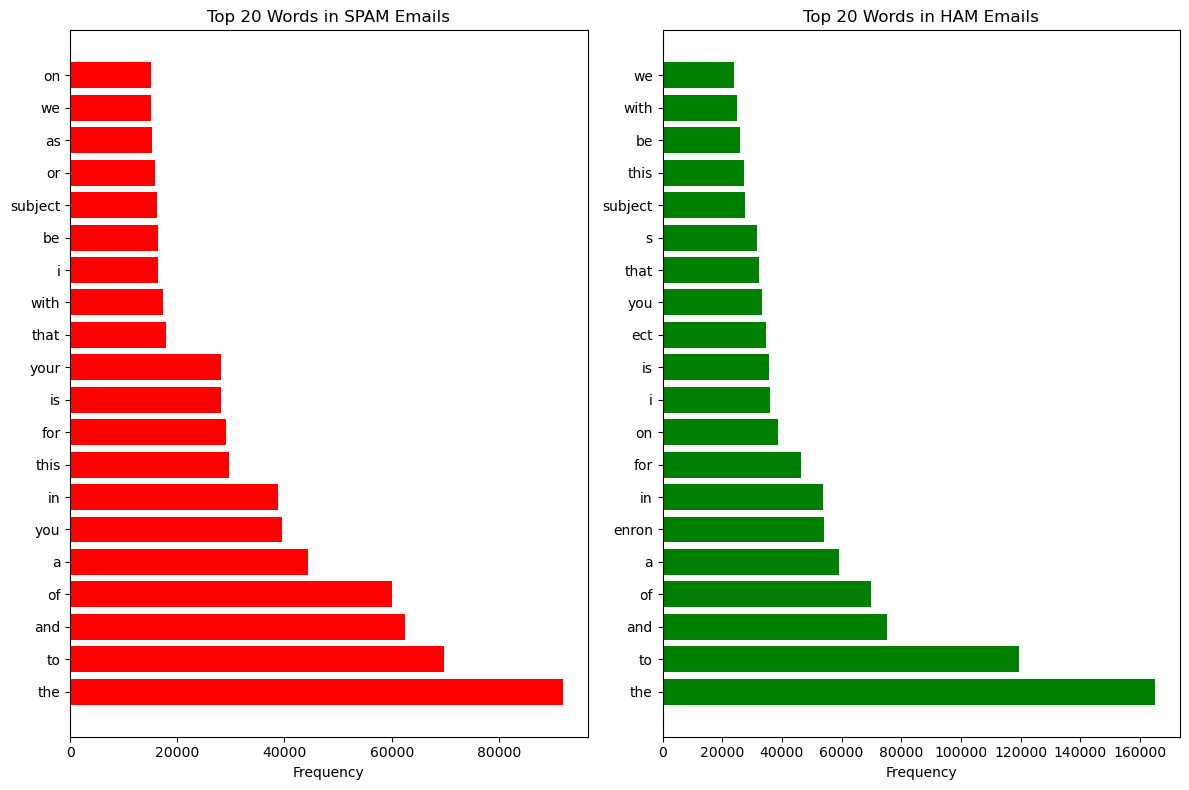

In [9]:
# STEP 2 -> COUNT MOST FREQUENT WORDS IN EACH CATEGORY
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_words(label, color):
    text = " ".join(df[df["label"] == label]["text"])  # Merge all emails of one label
    word_counts = Counter(text.split())  # Count words efficiently
    top_words = dict(word_counts.most_common(20))  # Get top 20 words

    plt.barh(list(top_words.keys()), list(top_words.values()), color=color)
    plt.title(f"Top 20 Words in {label.upper()} Emails")
    plt.xlabel("Frequency")

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot_top_words("spam", "red")
plt.subplot(1, 2, 2)
plot_top_words("ham", "green")
plt.tight_layout()
plt.show()


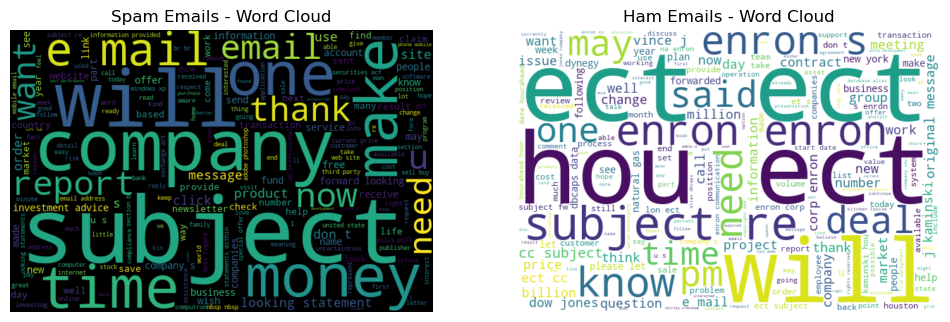

In [11]:
# STEP 3 -> VISUALIZE WORD FREQUENCIES
# install wordcloud library
!pip install wordcloud

from wordcloud import WordCloud

# Spam word cloud
spam_wc = WordCloud(width=600, height=400, background_color="black").generate(" ".join(df[df["label"] == "spam"]["text"]))

# Ham word cloud
ham_wc = WordCloud(width=600, height=400, background_color="white").generate(" ".join(df[df["label"] == "ham"]["text"]))

# plot word clouds
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(spam_wc, interpolation="bilinear")
plt.title("Spam Emails - Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ham_wc, interpolation="bilinear")
plt.title("Ham Emails - Word Cloud")
plt.axis("off")

plt.show()

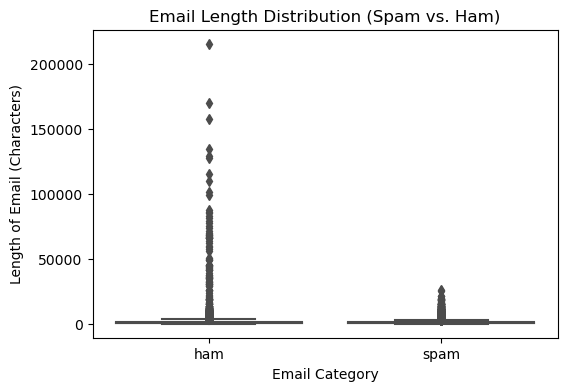

In [13]:
df["text_length"] = df["text"].apply(len)

plt.figure(figsize=(6,4))
sns.boxplot(x=df['label'], y=df['text_length'], palette=['blue', 'red'])
plt.title("Email Length Distribution (Spam vs. Ham)")
plt.xlabel("Email Category")
plt.ylabel("Length of Email (Characters)")
plt.show()

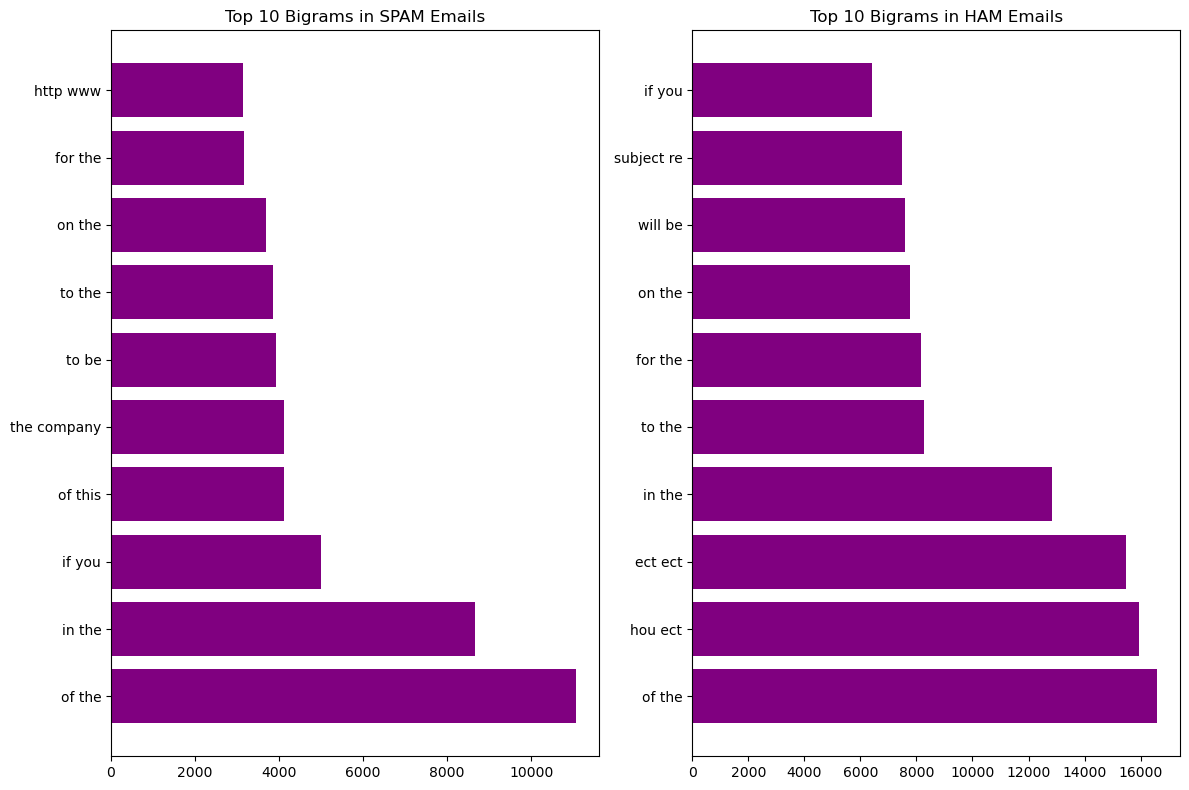

In [15]:
# STEP 4 -> find common bigrams -> Top 10 bigrams
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(label, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(df[df["label"] == label]["text"])
    bigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
    bigrams.columns = ["count"]
    bigrams = bigrams.sort_values("count", ascending=False).head(10)
    plt.barh(bigrams.index, bigrams["count"], color="purple")
    plt.title(f"Top 10 Bigrams in {label.upper()} Emails")

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plot_top_ngrams("spam")
plt.subplot(1, 2, 2)
plot_top_ngrams("ham")
plt.tight_layout()
plt.show()

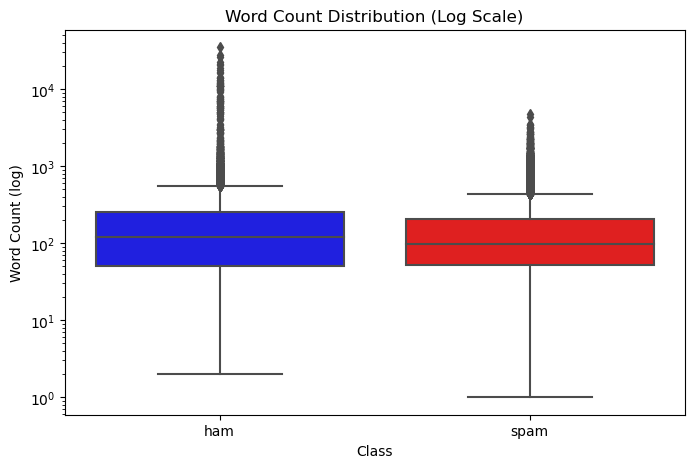

In [17]:
# Refine text analysis
# Word count instead of character length
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Plot with log scale for better outlier visibility
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='word_count', data=df, palette=['blue', 'red'])
plt.yscale('log')
plt.title("Word Count Distribution (Log Scale)")
plt.xlabel("Class")
plt.ylabel("Word Count (log)")
plt.show()

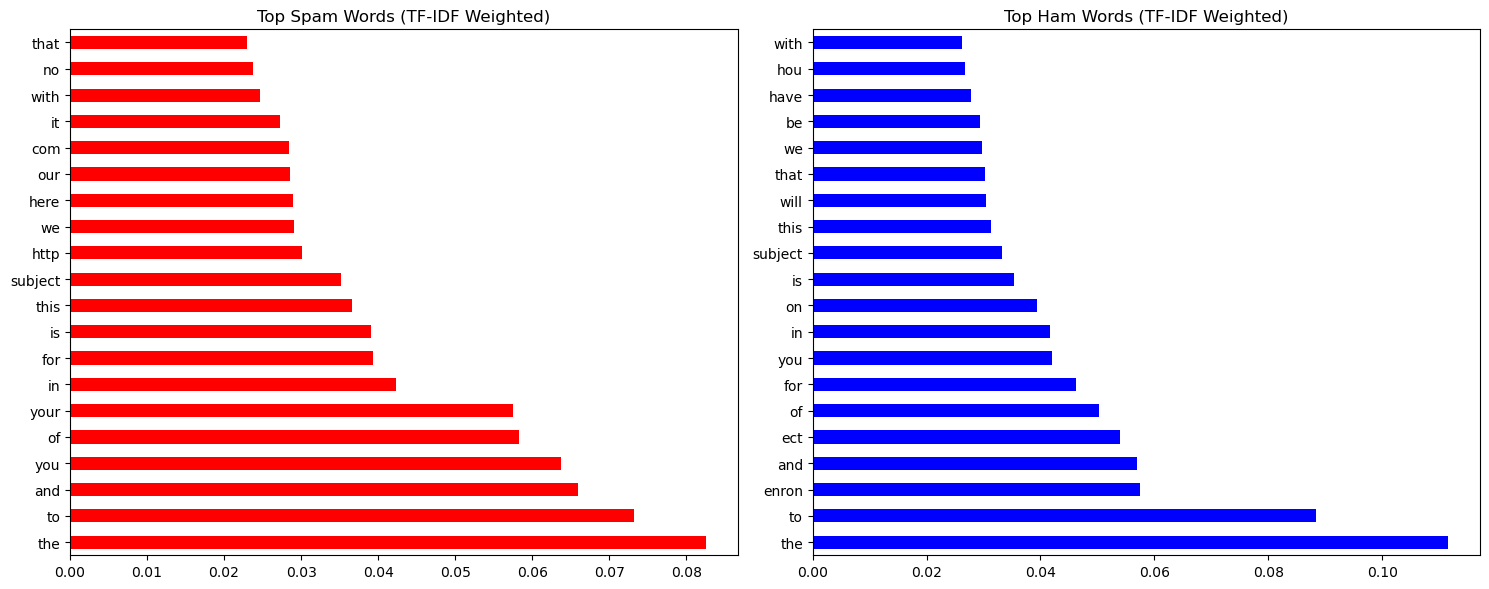

In [19]:
# Analyze TF-IDF Weighted Keywords
# Fit TF-IDF on the entire cleaned dataset (or training data if split)
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['text'])
feature_names = tfidf.get_feature_names_out()

# Get mean TF-IDF scores per class
spam_mask = (df['label'] == 'spam')
spam_tfidf_scores = tfidf_matrix[spam_mask].mean(axis=0).A1
ham_tfidf_scores = tfidf_matrix[~spam_mask].mean(axis=0).A1

# Top discriminative words for spam
spam_tfidf = pd.Series(spam_tfidf_scores, index=feature_names).sort_values(ascending=False).head(20)
ham_tfidf = pd.Series(ham_tfidf_scores, index=feature_names).sort_values(ascending=False).head(20)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
spam_tfidf.plot(kind='barh', ax=axes[0], color='red')
ham_tfidf.plot(kind='barh', ax=axes[1], color='blue')
axes[0].set_title("Top Spam Words (TF-IDF Weighted)")
axes[1].set_title("Top Ham Words (TF-IDF Weighted)")
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Suspicious Emails containing 'abuse program':
Empty DataFrame
Columns: [text]
Index: []


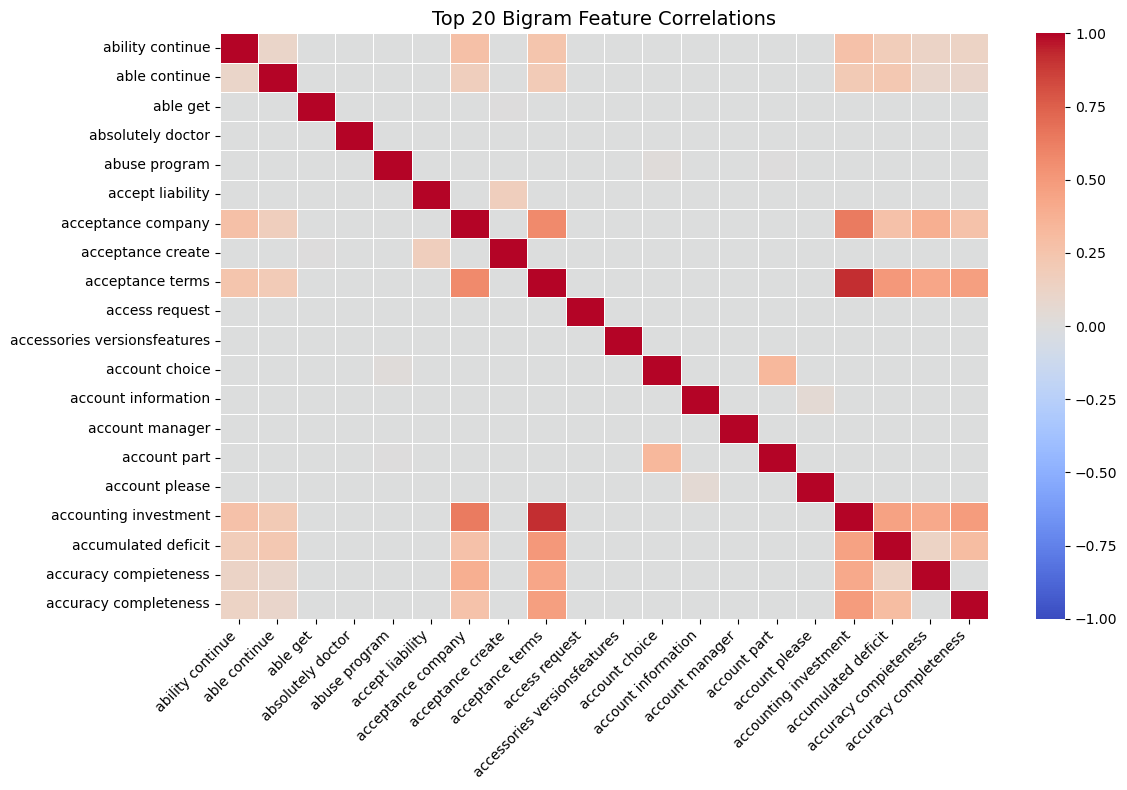

In [23]:
# TF-IDF Feature Correlation for top 20 TF-IDF features

# Import required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# 1. TF-IDF Vectorizer with Custom Parameters
# Define custom stopwords
custom_stopwords = ["abacha", "ac"]

# Initialize TF-IDF with combined parameters
tfidf = TfidfVectorizer(
    ngram_range=(2, 2),      # Focus on bigrams only
    max_features=5000,       # Reduce feature space
    stop_words=stopwords.words('english') + custom_stopwords,
    sublinear_tf=True,        # Apply sublinear TF scaling
    max_df=0.8  # Filter terms appearing in >80% of documents
)

# Transform text data
X = tfidf.fit_transform(df["text"])

# 2. Suspicious Pattern Investigation
# Analyze emails containing "abuse program"
spam_samples = df[df["label"] == "spam"]
suspicious_emails = spam_samples[spam_samples["text"].str.contains("abuse program")]
print("Suspicious Emails containing 'abuse program':")
print(suspicious_emails[["text"]].head())

# 3. Feature Correlation Analysis
# Get top 20 features and correlations
top_features = tfidf.get_feature_names_out()[:20]
corr_matrix = pd.DataFrame(X.toarray()[:, :20], columns=top_features).corr()

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
           annot=False, 
           cmap="coolwarm",
           vmin=-1, vmax=1,  # Fixed color scale
           linewidths=0.5)
plt.title("Top 20 Bigram Feature Correlations", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()